# Customer Life Value Optimization Model
Goal: Develop a model using A/B testing to strategise discount targeting for maximised Customer Life Value (CLV)

#### Importing Packages

In [142]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

print("Packages imported successfully!")

Packages imported successfully!


#### Importing the data

In [144]:
# Removing index, and customer ID columns
# We use the encoded data, not normalized; we only want the features normal, not the output
data = pd.read_csv("data/data_encoded.csv").drop(columns=["Unnamed: 0", "Customer ID"])

data.head()

,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,0,29,4,1,1120.20,14,4.6,1,25,1
1,1,34,2,2,780.50,11,4.1,0,18,0
2,0,43,0,0,510.75,9,3.4,1,42,2
3,1,30,5,1,1480.30,19,4.7,0,12,1
4,1,27,3,2,720.40,13,4.0,1,55,2


In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    348 non-null    int64  
 1   Age                       348 non-null    int64  
 2   City                      348 non-null    int64  
 3   Membership Type           348 non-null    int64  
 4   Total Spend               348 non-null    float64
 5   Items Purchased           348 non-null    int64  
 6   Average Rating            348 non-null    float64
 7   Discount Applied          348 non-null    int64  
 8   Days Since Last Purchase  348 non-null    int64  
 9   Satisfaction Level        348 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 27.3 KB


#### Creating interaction terms
Using the ETL script, we will create interaction terms based on highly correlated variables

In [146]:
data['Discount_Items_Interaction'] = data['Discount Applied'] * data['Items Purchased']
data['Discount_AverageRating_Interaction'] = data['Discount Applied'] * data['Average Rating']
data['Discount_Satisfaction_Interaction'] = data['Discount Applied'] * data['Satisfaction Level']
data['Discount_DaysSince_Interaction'] = data['Discount Applied'] * data['Days Since Last Purchase']
data['Membership_Age_Discount_Interaction'] = data['Membership Type'] * data['Age'] * data['Discount Applied']

In [147]:
# Step 3: Split Data into Treatment and Control Groups
treatment = data[data['Discount Applied'] == 1]
control = data[data['Discount Applied'] == 0]

### Part 1: Initial Model

In [148]:
# Define the features and target for treatment group
X_treatment = treatment.drop(columns = "Total Spend")
y_treatment = treatment['Total Spend']

In [149]:
# Define the features and target
X_control = control.drop(columns = "Total Spend")
y_control = control['Total Spend']

### Part 2: Testing Models

In [150]:
# Initialize models
treatment_model = GradientBoostingRegressor(random_state=42)
control_model = GradientBoostingRegressor(random_state=42)

# Train models
treatment_model.fit(X_treatment, y_treatment)
control_model.fit(X_control, y_control)

GradientBoostingRegressor(random_state=42)

In [159]:
# Predict CLV for both groups
treatment_predictions = treatment_model.predict(X_treatment)
control_predictions = control_model.predict(X_control)

# Calculate the expected uplift for each customer
data['Predicted_CLV_Treatment'] = treatment_model.predict(data[X_treatment.columns])
data['Predicted_CLV_Control'] = control_model.predict(data[X_control.columns])
data['Uplift'] = data['Predicted_CLV_Treatment'] - data['Predicted_CLV_Control']

data[['Predicted_CLV_Treatment','Predicted_CLV_Control','Uplift']].head()

,Predicted_CLV_Treatment,Predicted_CLV_Control,Uplift
0,1122.628460,1198.982209,-76.353749
1,963.775376,784.886331,178.889045
2,513.612307,457.266419,56.345888
3,1124.789001,1466.432276,-341.643275
4,716.512927,826.006900,-109.493973


In [161]:
data[['Predicted_CLV_Treatment','Predicted_CLV_Control','Uplift']].describe()

,Predicted_CLV_Treatment,Predicted_CLV_Control,Uplift
count,348.000000,348.000000,348.000000
mean,896.248133,879.550501,16.697632
std,235.467446,365.387608,256.630887
min,481.814153,420.601133,-390.514727
25%,690.504885,471.534732,-128.818067
50%,963.775376,816.398926,25.751805
75%,1118.405892,1198.289758,169.220577
max,1209.110035,1508.920619,505.093424


### Part 3: A/B Testing

In [133]:
# Create groups
control_group = data[data['Discount Applied'] == 0]['Total Spend']
test_group = data[data['Discount Applied'] == 1]['Total Spend']

Performing the t-test

In [134]:
t_stat, p_value = stats.ttest_ind(control_group, test_group, equal_var=False)
print(f'\nA/B Testing Results:')
print(f'Test Group Mean CLV: {test_group.mean():.2f}')
print(f'Control Group Mean CLV: {control_group.mean():.2f}')
print(f'T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}')


A/B Testing Results:
Test Group Mean CLV: 787.27
Control Group Mean CLV: 909.01
T-statistic: 3.17, P-value: 0.0017


### Part 4: Vizualizing the Variable Influence on CLV

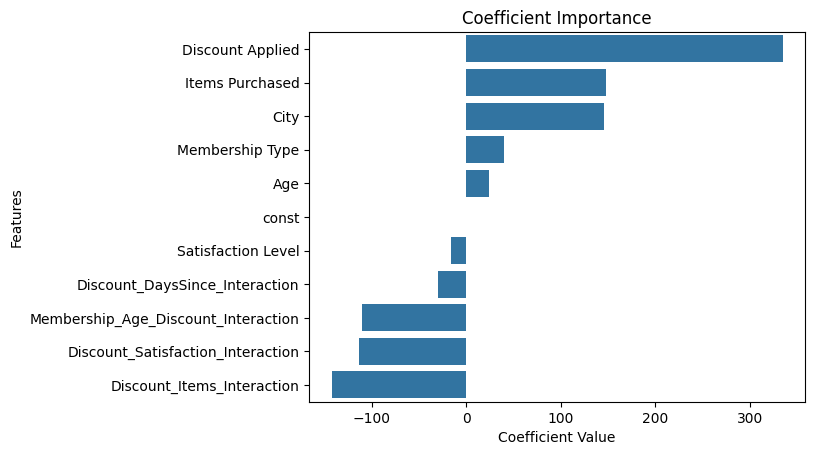

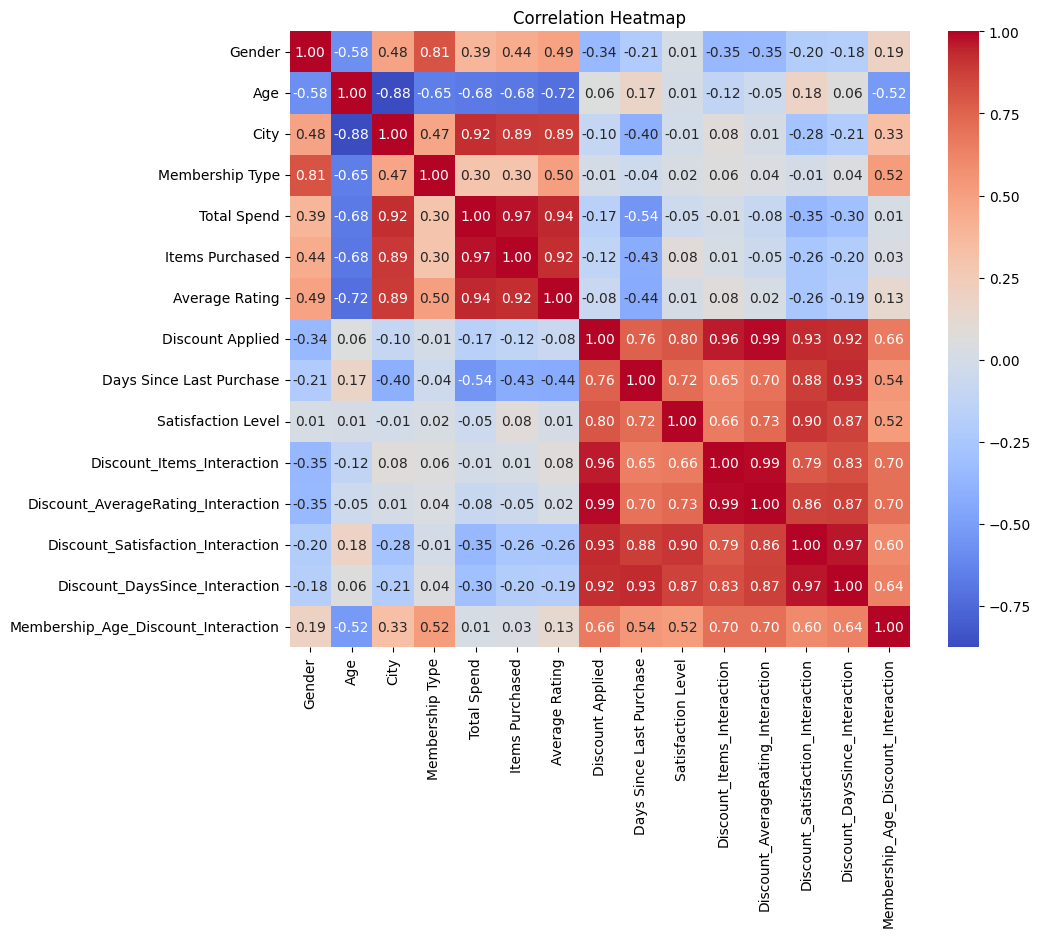

In [136]:
# Feature importance using the best model (e.g., if Random Forest or Gradient Boosting is selected)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.Series(best_model.feature_importances_, index=X_significant.columns).sort_values(ascending=False)
    sns.barplot(x=feature_importance.values, y=feature_importance.index)
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
elif hasattr(best_model, 'coef_'):
    coef = pd.Series(best_model.coef_, index=X_significant.columns).sort_values(ascending=False)
    sns.barplot(x=coef.values, y=coef.index)
    plt.title('Coefficient Importance')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.show()


# Correlation heatmap to visualize relationships
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Part 5: Analysis of Model's Impact on Revenue


Revenue Impact Analysis:
Baseline Total CLV: $295032.00
Post-Model Total CLV: $188317.78
Increased CLV by -36.17% after applying the model.


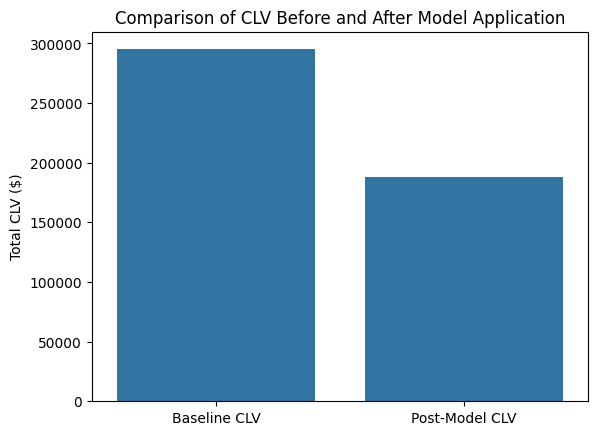

In [140]:
# Calculate the baseline CLV (before applying the model)
baseline_clv = data['Total Spend'].sum()

# Predict CLV with the best model on test set
data['Predicted_CLV'] = best_model.predict(X_significant)

# Calculate the new average CLV after applying the model's predictions
post_model_clv = data['Predicted_CLV'].sum()

# Calculate the increase in CLV
clv_increase = ((post_model_clv - baseline_clv) / baseline_clv) * 100

print(f'\nRevenue Impact Analysis:')
print(f'Baseline Total CLV: ${baseline_clv:.2f}')
print(f'Post-Model Total CLV: ${post_model_clv:.2f}')
print(f'Increased CLV by {clv_increase:.2f}% after applying the model.')

# (Optional) Visualize the improvement in CLV
sns.barplot(x=['Baseline CLV', 'Post-Model CLV'], y=[baseline_clv, post_model_clv])
plt.title('Comparison of CLV Before and After Model Application')
plt.ylabel('Total CLV ($)')
plt.show()